# 시계열 분석 
| 시간의 흐름에 따라 기록된 데이터를 바탕으로 미래의 변화에 대한 추세를 분석하는 방법

* 시간에 따라 데이터의 추세가 어떠한지, 시각 외에 어떠한 외부요인이 데이터에 영향을 미치는지 고려

## 시계열 분해

| 시계열 자료를 추세(Trend), 계절성(Seasonality), 잔차(Residual)로 분해하는 기법
    * 시간 요인: 추세, 계절성
    * 외부요인: 잔차(불규칙 요인)

1. 모형 판단
- 추세와 계절성이 별개로 존재 -> Additive 모형
- 추세에 따라 계절성 존재 -> Multiplicative 모형
    - 추세에 따라 계절성의 변동폭에도 변화가 존재한다면!

### 예제) 승법 활용 시계열 분해

In [1]:
# python 활용 시계열 분해
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/arima_data.csv', names=['day', 'price'])
data.info()
# day (object) -> (datetime)
data['day'] = pd.to_datetime(data['day'], format = "%Y-%m-%d")
data.set_index('day', inplace=True) # day 컬럼을 인덱스로 지정하여 단일 컬럼 df로 만듦

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     60 non-null     object
 1   price   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


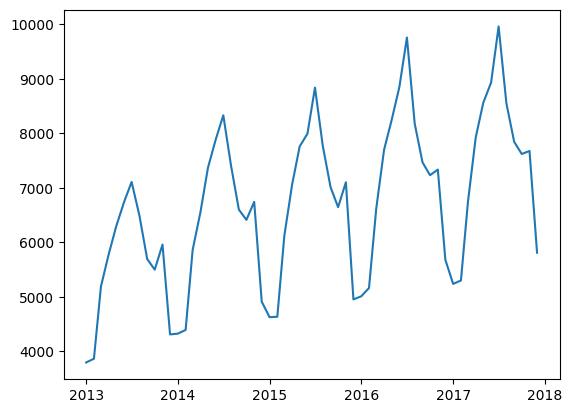

In [2]:
import matplotlib.pyplot as plt
plt.plot(data.index, data['price']);

* 시간이 지날수록 변동이 커지므로 Multiplicative(승법)을 적용하여 시계열 분해

<Figure size 1500x1000 with 0 Axes>

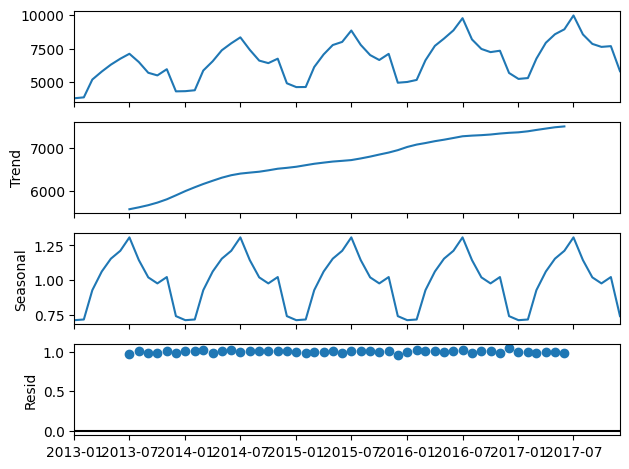

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose # 시계열 분해
ts = data # 단일컬럼 df
result = seasonal_decompose(ts, model='multiplicative')
plt.figure(figsize=(15, 10))
result.plot();


* 본 데이터는 Trend와 Seasonal이 명확히 존재하며, 불규칙 요인은 거의 없음을 알 수 있음(잔차 일정)

## ARIMA 모델
| AR(Auto-Regressive)모형과 MA(Moving-Average)모형을 합한 모형

1. 정상성이란

* 평균, 분산이 시간에 따라 일정한 성질을 가지고 있다는 것 -> 시계열의 특성이 시간의 흐름에 따라 변하지 않는 상태
* ARIMA 모형을 적용시키려면 비정상 시계열을 정상 시계열로 변화해주어야 함
    * 로그 변환 - 분산(변동폭)이 일정하지 않은 경우에 사용
    * 차분 - 로그 변환 후 추세, 계절성이 존재하는 경우에 사용

### 예제)정상성 검정
* 정상성 검정을 위해선 Augmented Dickey-Fuller Test를 해야한다.

    귀무가설: 데이터가 정상성을 갖지 않는다

```statsmodels.tsa.stattools.adfuller(x, regression)```

* x: 2개의 관측값으로 이루어진 binary data를 배열형식으로 입력 ex) 날짜 index, 관측값 value인 DataFrame
* regression: 테스트의 버전으로 추세 존재 여부에 따라 선택

    ```return t-statistic, p-value```

In [4]:
from statsmodels.tsa.stattools import adfuller 

# train, test
train = data[:'2016-12-01']
test = data.drop(train.index)
adf = adfuller(train, regression='ct') # 'ct' 추세가 존재하는 경우 (추세+상수항)
print(f'''
ADF Statistic: {adf[0]}
p-value: {adf[1]}''')



ADF Statistic: -1.999719934132733
p-value: 0.6015863303794432


* p-value > 0.05로 해당 데이터는 정상성을 갖지 않음

    -> 로그 변환 & 차분 필요

### 예제) 로그변환 및 차분 -> 정상성 변환

```df.diff()``` 행과 행의 차이값 계산, 첫 행을 이전 행이 없으므로 NaN값
* 1차 차분 ```.diff(1)```

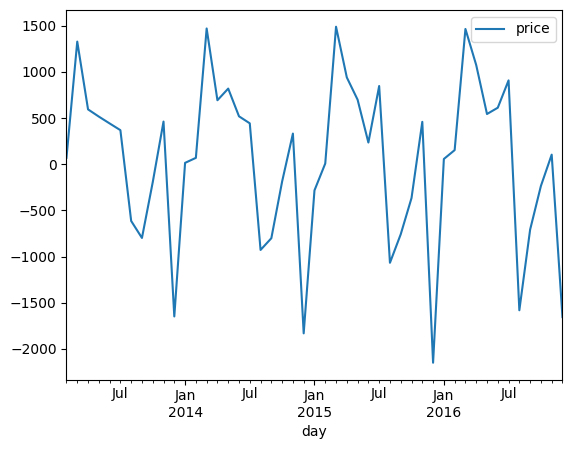

In [5]:
# 추세 요인 제거
diff_data = train.diff(1).iloc[1:] # 첫행 NaN
diff_data.plot();

In [6]:
# 정상성 재검정
adf = adfuller(diff_data, regression='c') # 추세요인이 없기 때문에 상수항 적용
print(f'''
ADF Statistic: {adf[0]}
p-value: {adf[1]}''')


ADF Statistic: -12.09454757692639
p-value: 2.0851606399613965e-22


* p-value < 0.05로 정상성 만족

### ACF와 PACF

1. ACF(Auto Correlation Function): 자기상관 함수

    **시차에 따른 자기 상관성**

    - 비정상 시계열일 경우 ACF값은 느리게 0에 수렴

    - MA모형의 q값 선정에 사용

2. PACF(Partial Auto Correlation Function): 편자기상관 함수

    **과거 t시점까지의 데이터와 현재시점의 데이터와의 상관성**

    - ACF와 다르게 시차가 다른 두 시계열 간 순수한 상호 연관성을 나타낸다

    - AR모형의 p값 선정에 사용 

### AR모형과 MA모형

AR 모형 - 자기 회귀

* 현 시점의 데이터를 이전의 데이터들의 상관성으로 나타내는 모형
* 과거의 값이 현재의 값에 얼마나 영향을 미쳤는지를 파악하는 것

| 만약 과거의 값이 현재 값에 영향을 미치지 않는다면 모형의 성능은 낮아진다

    이때, 최적의 성능을 가질 수 있는 과거 값을 찾는데, 이 값을 p라고 하며 AR(p)모형이라고 함

AR모형의 p값 찾기
```plot_pacf(df)```



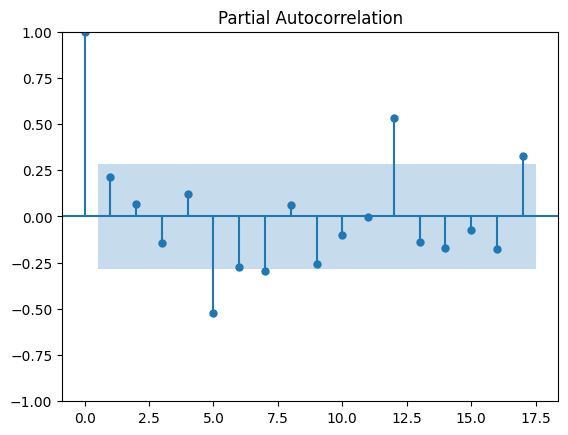

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(diff_data)

plt.show();

MA 모형의 q값 찾기
```plot_acf(df)```

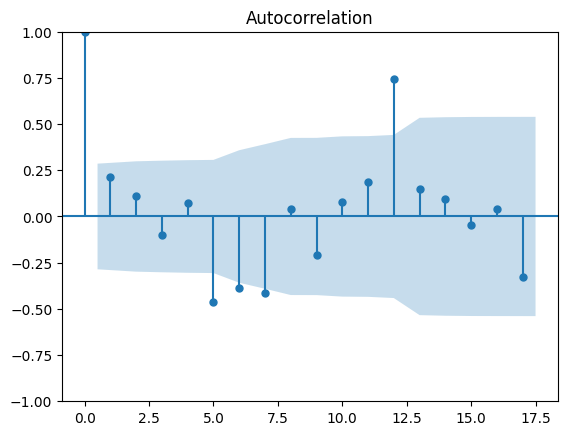

In [8]:
plot_acf(diff_data)
plt.show();

### 예제) ARIMA 모델링

ARIMA는 비정상적 시게열 자료에 대해 차분을 사용하여 정상 시계열로 만든다

정상 시계열의 경우 AR, MA 모형이 상호 변환 가능하기에 두 모형을 결합하여 과거 시점의 데이터로 현재 혹은 미래 데이터를 예측하는 모형이다

파라미터로는 p(AR 시차), d(차분 횟수), q(MA 시차)

In [9]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(2,1,2))
result = model.fit()
result.summary()

/Users/sai/anaconda3/envs/section4_pj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sai/anaconda3/envs/section4_pj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sai/anaconda3/envs/section4_pj/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/sai/anaconda3/envs/section4_pj/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Wed, 03 Apr 2024   AIC                            761.750
Time:                        15:10:57   BIC                            771.001
Sample:                    01-01-2013   HQIC                           765.231
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3167      0.190     -6.920      0.000      -1.690      -0.944
ar.L2         -0.3191      0.191     -1.670      0.095      -0.694       0.055
ma.L1          1.9692      0.244      8.074      0.000       1.491       2.447
ma.L2          0.9941      0.243      4.098      0.000       0.519       1.470
sigma2      4.455e+05   1.15e-06   3.88e+11      0.000    4.45e+05    4.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.1e+29. Standard errors may be unstable.
"""

* AIC가 작을수록 성능이 좋다고 할 수 있음

* summary() 출력값의 모형.Ln 변수는 입력한 p, q값에 따라 변수 개수가 만들어지는 것

* AR, MA의 모델의 회귀계수가 유의하기 때문에 두 모형을 사용할 수 있음

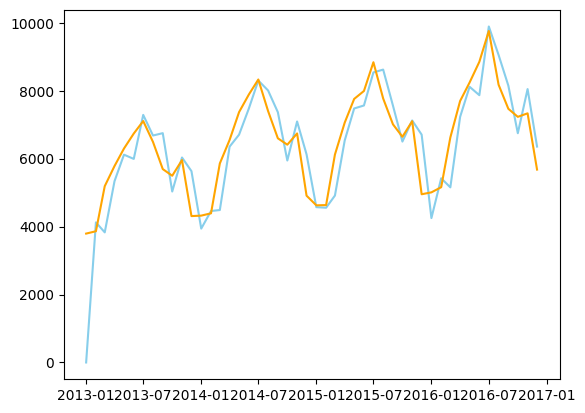

In [10]:
# 예측값 시각화
plt.plot(result.predict(), color='skyblue') # 예측값
plt.plot(train, color='orange') # 관측값

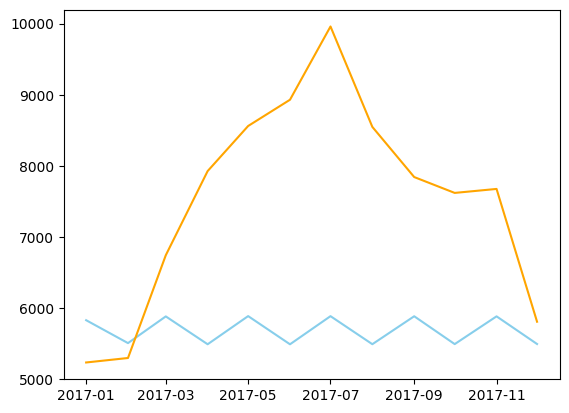

In [11]:
# 예측
forecast = result.forecast(steps=len(test), alpha=.05)
# 학습데이터 셋으로부터 test 길이만큼 에측

# 예측 시각화
plt.plot(forecast, color='skyblue') # 예측값
plt.plot(test, color='orange');

In [12]:
# 회귀 성능 지표 확인
from sklearn.metrics import *
import numpy as np

print(f'''
r2 score: {r2_score(test, forecast)}
RMSE: {np.sqrt(mean_squared_error(test, forecast))}''')


r2 score: -1.6432459219844344
RMSE: 2302.3506971082043


* ARIMA의 경우 긴 값을 예측할 때, 표본 평균으로 회귀하려는 경향 때문에 성능이 떨어짐

* 계절성을 띠는 데이터의 경우 계절성지수가 추가된 SARIMA 모델을 사용하는 것이 좋음

In [13]:
# ! pip install pmdarima
# 시계열 Grid_search를 지원해주는 패키지

## SARIMA 모델

| 데이터가 지닌 계절성까지 고려한 ARIMA 모델

* 계절성이 몇 개의 데이터 단위로 나타나는 지 확인 -> s값 선정 (월단위)
    * 시각화로 판단하는 것이 가장 빠름

* seasonal_order의 파라미터 최적화 -> ```! pip install pmdarima```

```pmdarima.auto_arima```

(dataframe,

start_p=최적 AR모형을 위한 p의 시작값, d=차분 횟수, start_q=최적 MA모형을 위한 q의 시작값,

max_p=p의 최대값, max_q=q의 최대값,

start_P=최적 모델을 위한 자동 회귀 차수 P의 시작값, start_Q=최적 모델을 위한 이동 평균 차수 Q의 시작값,

max_P=P의 최대값, max_Q=Q의 최대값, m=계절성의 주기(s값),

seasonal=계절성 존재 여부, information_criterion=모델 평가지표,('aic','aicc','hqic','oob') # 주로 aic

trace=추적 여부)


### 예제)

In [14]:
from pmdarima import auto_arima

auto_model = auto_arima(
    train, start_p=0, d=1, start_q=0,
    max_p=3, start_P=0, start_Q=0,
    max_P=3, max_Q=3, m=12,
    seasonal=True, information_criterion='aic',
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=481.846, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.652, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=482.466, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=483.637, Time=0.21 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=483.669, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=481.031, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=482.740, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=482.616, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=482.682, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=480.687, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=482.403, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=48

* p, d, q, P, D, Q, m 순으로 해석

In [15]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -238.344
Date:                             Wed, 03 Apr 2024   AIC                            480.687
Time:                                     15:44:44   BIC                            483.798
Sample:                                 01-01-2013   HQIC                           481.761
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3185      0.177     -1.801      0.072      -0.665       0.028
sigma2      4.803e+04   1.64e+04      2.924      0.003    1.58e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.95   Prob(JB):                         0.56
Heteroskedasticity (H):               1.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

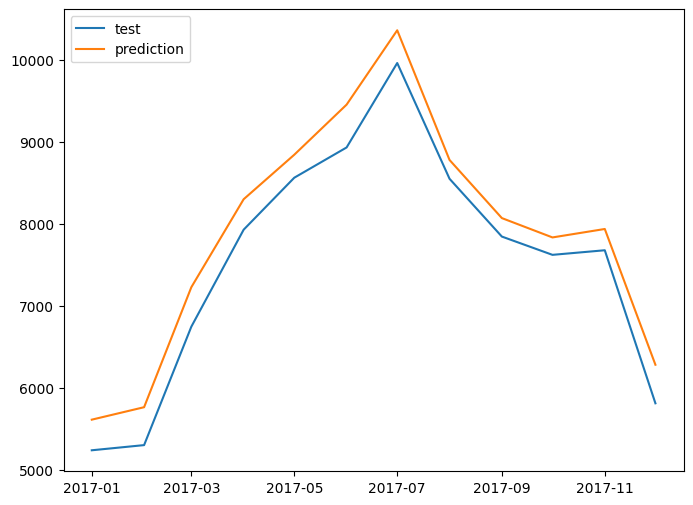

In [17]:
# 예측(predict)
pred_t = auto_model.predict(n_periods=len(test), index=test.index)
# 시각화
plt.figure(figsize=(8,6))
plt.plot(test, label='test')
plt.plot(pred_t, label='prediction')
plt.legend(loc='upper left');

## ARIMA & SARIMA 성능비교

In [18]:
def compare(preds):
    for i, pred in enumerate(preds):
        r2 = r2_score(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        print(f'''
              pred{i+2} r2: {r2}
              pred{i+2} rmse: {rmse}''')
compare([forecast, pred_t])


              pred2 r2: -1.6432459219844344
              pred2 rmse: 2302.3506971082043

              pred3 r2: 0.9305467058853065
              pred3 rmse: 373.2064282752658


* SARIMA 모델은 데이터를 93% 설명하고 있고, 평균오차는 373원으로 매우 높은 정확도를 보임
    * 이 데이터는 시간의 추세와 계절성만을 가지고 예측할 수 있다는 의미
    
    -> 가격은 시간의 영향을 많이 받는다 